In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import joblib

# Bước 1: Đọc dữ liệu
file_path = "sensor_data.csv"
df = pd.read_csv(file_path)

# Bước 2: Xử lý dữ liệu
# Chuyển đổi giá trị thành số thực
df = df.astype(float)

# Xây dựng nhãn
def classify_health_state(avg_bpm, a_total):
    # Trường hợp BPM trong khoảng 60-110
    if 60 <= avg_bpm <= 110:
        if a_total < 12:
            return "Bình thường"
        elif 12 <= a_total < 20:
            return "Hoạt động nhẹ"
        elif 20 <= a_total < 35:
            return "Hoạt động trung bình"
        else:
            return "Hoạt động mạnh"

    # Trường hợp BPM quá thấp hoặc quá cao
    if avg_bpm < 60:
        if a_total < 12:
            return "Cảnh báo sức khoẻ không ổn định"
        elif a_total >= 35:
            return "Hoạt động mạnh bất thường"

    if avg_bpm > 110:
        if a_total < 12:
            return "Nhịp tim cao bất thường"
        elif 12 <= a_total < 35:
            return "Hoạt động thể chất mạnh"
        else:
            return "Hoạt động cực độ"

    # Trường hợp đặc biệt sức khỏe tốt hoặc rất xấu
    if avg_bpm < 50 and a_total < 12:
        return "Sức khỏe siêu tốt"

    if avg_bpm > 150 and a_total > 35:
        return "Cảnh báo nguy hiểm"

    return "Không xác định"

# Tạo cột nhãn
df["label"] = df.apply(lambda row: classify_health_state(row["AvgBPM"], row["A_total"]), axis=1)

# Xóa dữ liệu không xác định
df = df[df["label"] != "Không xác định"]


# Chuyển nhãn thành số
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])

# Lưu encoder
joblib.dump(label_encoder, "label_encoder.pkl")

# Chọn đặc trưng đầu vào
X = df[["AvgBPM", "A_total"]].values
y = df["label"].values

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Lưu scaler
joblib.dump(scaler, "scaler.pkl")

# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kiểm tra sự mất cân bằng dữ liệu
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Bước 3: Xây dựng mô hình
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(2,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(len(np.unique(y)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Bước 4: Huấn luyện mô hình với EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test),
          callbacks=[early_stopping], class_weight=class_weight_dict)

# Bước 5: Lưu mô hình
model.save("health_model.h5")
print("Mô hình đã được lưu thành công!")

# Kiểm tra độ chính xác trên tập test
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Độ chính xác trên tập test: {test_acc:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4206 - loss: 1.7939 - val_accuracy: 0.9636 - val_loss: 0.2135
Epoch 2/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9435 - loss: 0.9054 - val_accuracy: 0.9694 - val_loss: 0.1387
Epoch 3/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9561 - loss: 0.7656 - val_accuracy: 0.9681 - val_loss: 0.1607
Epoch 4/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9592 - loss: 0.5191 - val_accuracy: 0.9700 - val_loss: 0.1855
Epoch 5/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9619 - loss: 0.4972 - val_accuracy: 0.9700 - val_loss: 0.2001
Epoch 6/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9613 - loss: 0.4213 - val_accuracy: 0.9665 - val_loss: 0.2057
Epoch 7/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9637 - loss: 0.3304 - val_accuracy: 0.9691 - val_loss: 0.1855
Epoch 8/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9697 - loss: 0.3813 - val_acc

Mô hình đã được lưu thành công!
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9721 - loss: 0.1346
Độ chính xác trên tập test: 0.9694


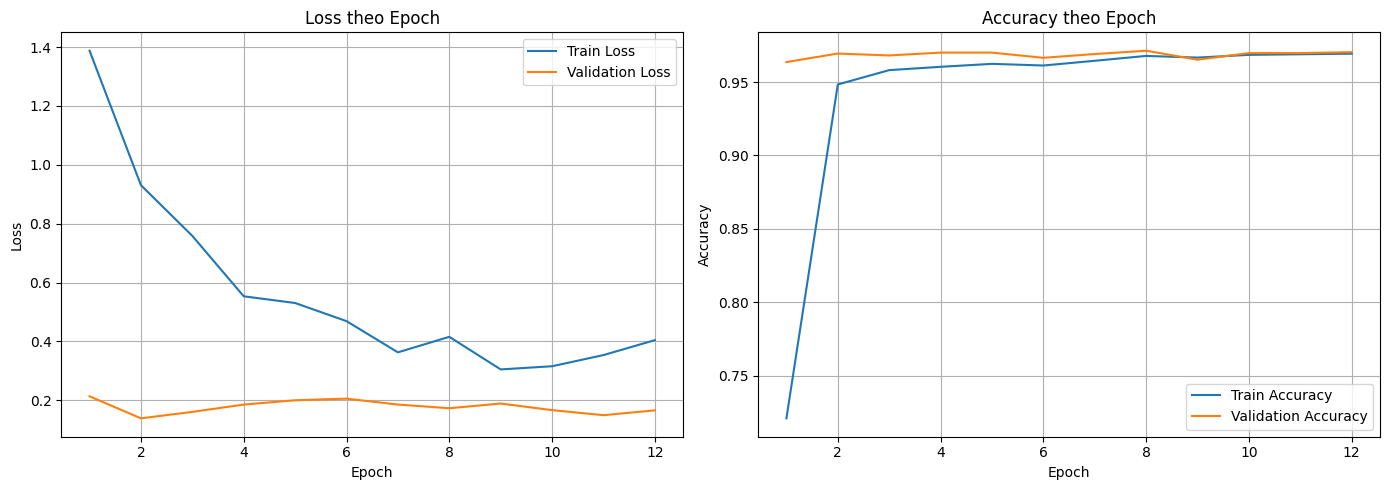

In [4]:
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 5))

# --- Biểu đồ LOSS ---
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss theo Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Biểu đồ ACCURACY ---
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy theo Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
